In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = '../models'
LOG_DIR = '../logs/01b/2/'


caminho_bases = os.path.join('..', 'bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

# Callbacks

In [2]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=False,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'Bmodelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=1, min_delta=1e-2, mode='min')


# Model

In [3]:
SIZE = (224, 224)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
#  GlobalAveragePooling2D(),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

# Training and validation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=True,
)

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary'
)

Found 20845 images belonging to 2 classes.
Found 2317 images belonging to 2 classes.


In [5]:
epoch = 15
val_loss = 0.13
model.load_weights(
    os.path.join(MODEL_DIR,
                 'Bmodelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))


In [46]:
history = model.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

Epoch 1/30
326/326 [==============================] - 182s 558ms/step - loss: 0.3009 - acc: 0.8965 - val_loss: 0.2065 - val_acc: 0.9279
Epoch 2/30
326/326 [==============================] - 181s 554ms/step - loss: 0.2074 - acc: 0.9399 - val_loss: 0.1843 - val_acc: 0.9534
Epoch 3/30
326/326 [==============================] - 183s 560ms/step - loss: 0.2112 - acc: 0.9452 - val_loss: 0.1512 - val_acc: 0.9551
Epoch 4/30
326/326 [==============================] - 176s 539ms/step - loss: 0.1690 - acc: 0.9520 - val_loss: 0.1573 - val_acc: 0.9581
Epoch 5/30
326/326 [==============================] - 178s 547ms/step - loss: 0.2089 - acc: 0.9489 - val_loss: 0.1405 - val_acc: 0.9590
Epoch 6/30
326/326 [==============================] - 176s 540ms/step - loss: 0.1712 - acc: 0.9516 - val_loss: 0.1386 - val_acc: 0.9607
Epoch 7/30
325/326 [============================>.] - ETA: 0s - loss: 0.1702 - acc: 0.9527
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
326/326 [===

# Evaluation

In [48]:
%load_ext autoreload
%autoreload 2
from utils import get_imagens_erro, report
import time

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 64
t0 = time.time()
y_test, y_pred, X_names_test = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2317 images belonging to 2 classes.
4736 imagens processadas em 9.948302268981934 segundos (0.0021005705804438206 por imagem)


In [37]:
report(validation_generator, y_test, y_pred)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 1078 	 88
vazio 	 1 	 1150
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1166
         1.0       0.93      1.00      0.96      1151

    accuracy                           0.96      2317
   macro avg       0.96      0.96      0.96      2317
weighted avg       0.96      0.96      0.96      2317



{0: 'nvazio', 1: 'vazio'}


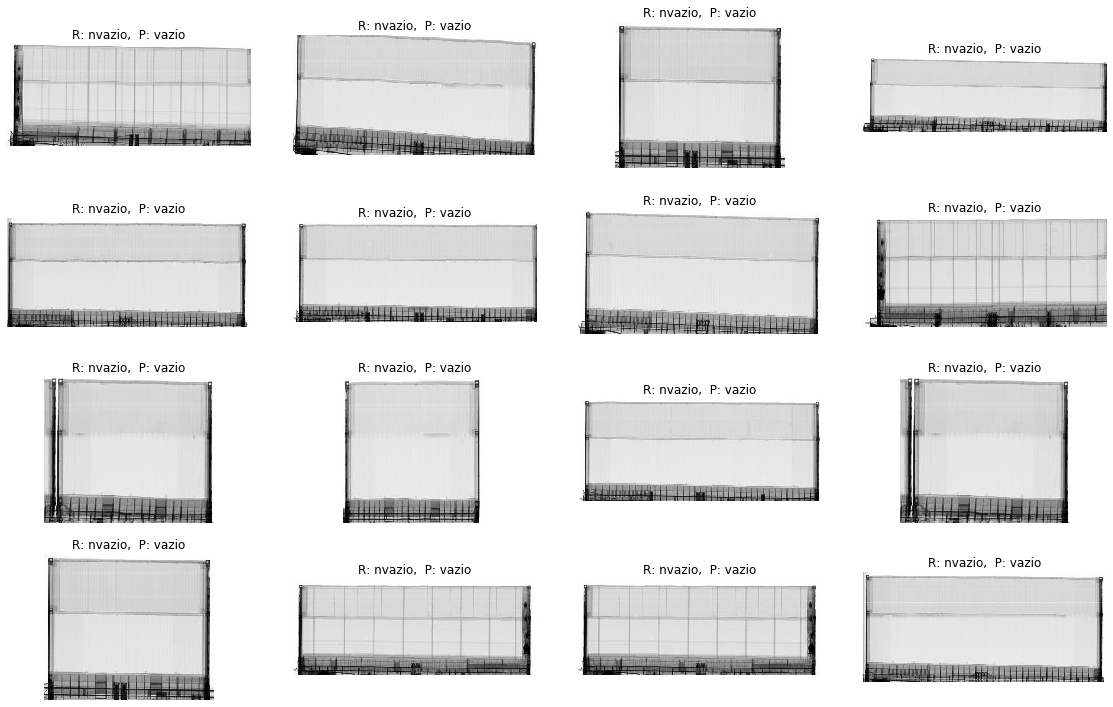

In [41]:
from utils import plot_errors
plot_errors(validation_generator, y_test, y_pred, caminho_test, X_names_test)

In [43]:
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

s = len(train_generator) * 128
t0 = time.time()

y_train, y_pred_train, X_names_train = get_imagens_erro(train_generator, model)

elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 20845 images belonging to 2 classes.
20864 imagens processadas em 97.51268601417542 segundos (0.004673729199299052 por imagem)


In [44]:
report(train_generator, y_train, y_pred_train)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 9638 	 856
vazio 	 5 	 10346
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     10494
         1.0       0.92      1.00      0.96     10351

    accuracy                           0.96     20845
   macro avg       0.96      0.96      0.96     20845
weighted avg       0.96      0.96      0.96     20845



{0: 'nvazio', 1: 'vazio'}


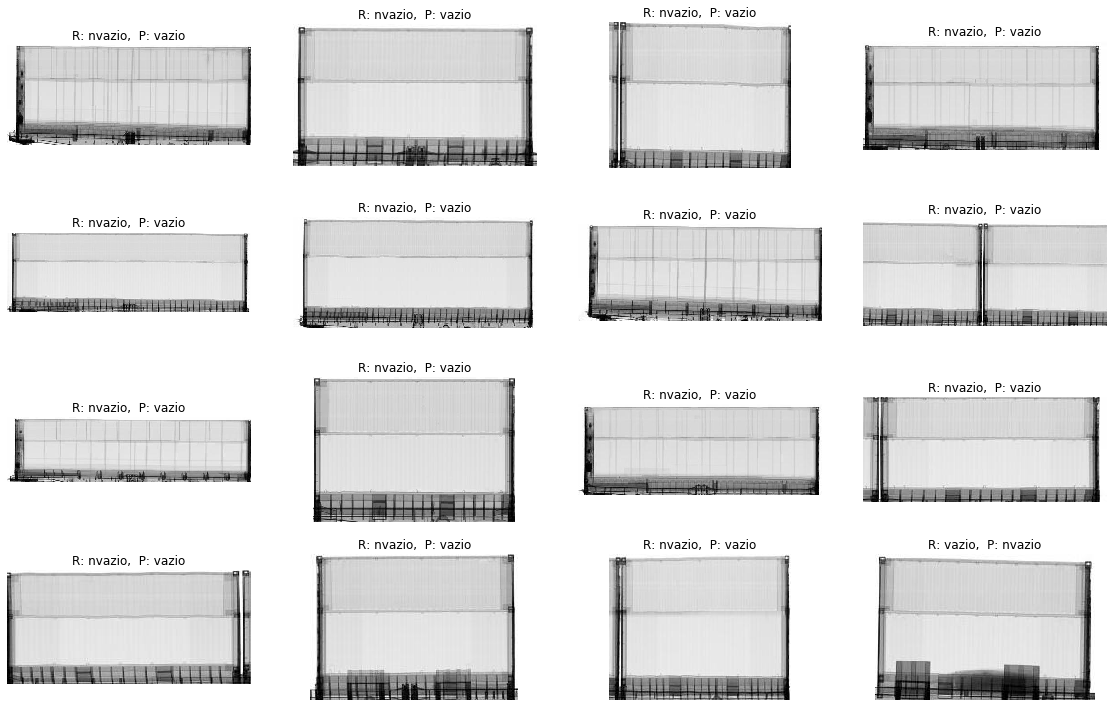

In [47]:
plot_errors(train_generator, y_train, y_pred, caminho_train, X_names_train)